Compare different methods of calculating z-statistics from multiple regression with relatively low degrees of freedom. We use this to generate z-statistic maps corresponding to our PCA and ICA components in tedana.

In [1]:
%matplotlib inline
import os.path as op
import matplotlib.pyplot as plt

import numpy as np
import nibabel as nib
from nilearn import masking
from scipy import stats
from nilearn.mass_univariate import permuted_ols
from nimare.stats import p_to_z
import seaborn as sns

/Users/tsalo/.local/lib/python3.6/site-packages/scikit_learn-0.21.2-py3.6-macosx-10.7-x86_64.egg/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def rmse(pred, truth):
    """
    https://stackoverflow.com/a/26072309/2589328
    """
    return np.sqrt(np.mean((pred - truth) ** 2))

In [3]:
# We'll want a reduced set of voxels to speed up calculations
voxel_idx = np.arange(1000, 2000, dtype=int)

In [4]:
# Constants
# We'll use the optimally combined data and PCA mixing matrix for our test
data_dir = '/Users/tsalo/Documents/tsalo/tedana-comparison/sandbox/e5-checkerboard'
data_file = op.join(data_dir, 'ts_OC.nii.gz')
mixing_file = op.join(data_dir, 'mepca_mix.1D')

mask = masking.compute_epi_mask(data_file)
data = masking.apply_mask(data_file, mask)
data = data[:, voxel_idx]  # Reduce number of voxels for speed

mixing = np.loadtxt(mixing_file)
mixing = mixing#[:, :50]  # Reduce number of components to get some DOFs

In [5]:
# Method 1: The tedana way
from tedana.stats import computefeats2
Z_MAX = 8

# First, we calculate "standardized" parameter estimates
# (mixing is not normalized in the function, but data is).
# These PEs are truncated at +- 1 and converted to
# normally-distributed Z-values (not valid Z-statistics)
# using the Fisher R-to-Z transform.
z_val_maps1 = computefeats2(data.T, mixing, normalize=False)

# Tedana then z-scores the z-values and treats these as valid z-statistics
z_stat_maps1 = stats.zscore(z_val_maps1, axis=0)  # Normalize each component map across voxels
z_stat_maps1[np.abs(z_stat_maps1) > Z_MAX] = Z_MAX * np.sign(z_stat_maps1[np.abs(z_stat_maps1) > Z_MAX])

16429/159000 bad voxels found


In [6]:
# Method 2: Adapted tedana way
# The attempt here is to calculate properly standardized
# PEs by normalizing the data *and* the mixing matrix, then
# apply Fisher R-to-Z (done in function).
data_vn = stats.zscore(data, axis=-1)  # normalize each voxel over time
mixing_z = stats.zscore(mixing, axis=0)  # normalize each component over time
z_val_maps2 = computefeats2(data_vn.T, mixing_z, normalize=False)

# We then can convert Z-values to Z-statistics by dividing
# by the standard error (1 / sqrt(n -3)), but determining the
# degrees of freedom is *hard* (impossible?) here, because
# the DOF for the regression is #Volumes - #Components
# So instead I've decided to use the Z-values directly

# NOTE: Incorporating degrees of freedom *increases* RMSE
# z_stat_maps2 = z_val_maps2 * np.sqrt((mixing.shape[0] - mixing.shape[1]) - 3)

z_stat_maps2 = z_val_maps2

0/159000 bad voxels found


In [7]:
# Method 3: Nilearn
# Here we try using a permutation-based approach to estimate
# voxel- and component-wise significance based on an empirical
# null distribution.
# We want to see how well a small number of permutations (500)
# compares to a much larger number
nilearn_test_maps = []
for i_test in range(50):  # Run many times to get a distribution
    pe_logp_vals, pe_t_vals, _ = permuted_ols(
        mixing, data, model_intercept=True, n_jobs=4,
        n_perm=500, verbose=0)
    pe_p_vals = np.power(10., -pe_logp_vals)
    pe_z_vals = p_to_z(pe_p_vals, tail='two')
    pe_z_vals *= np.sign(pe_t_vals)
    z_stat_maps3 = pe_z_vals
    nilearn_test_maps.append(z_stat_maps3)

In [8]:
# Ground truth: Nilearn + lots of perms
pe_logp_vals, pe_t_vals, _ = permuted_ols(
    mixing, data, model_intercept=True, n_perm=50000, n_jobs=4, verbose=3)
pe_p_vals = np.power(10., -pe_logp_vals)
pe_z_vals = p_to_z(pe_p_vals, tail='two')
pe_z_vals *= np.sign(pe_t_vals)
z_stat_maps0 = pe_z_vals

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.4min finished


/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


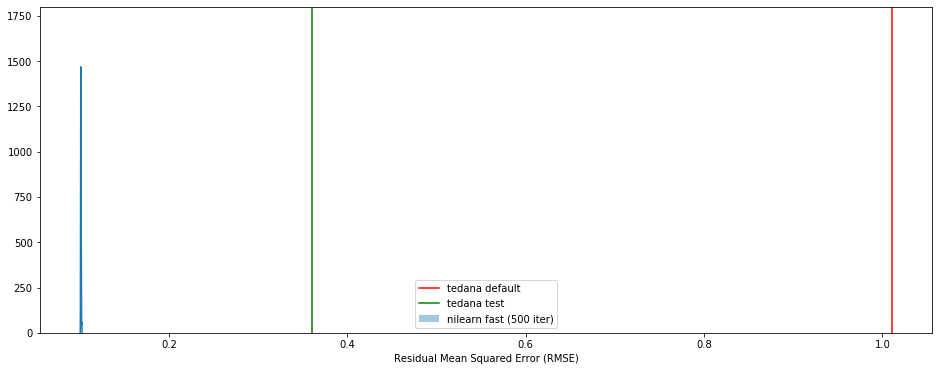

In [10]:
# Compute RMSE values between each test array and the ground truth array
# Then plot
rmse1 = rmse(z_stat_maps1.T, z_stat_maps0)
rmse2 = rmse(z_stat_maps2.T, z_stat_maps0)
rmse3 = []
for i in range(len(nilearn_test_maps)):
    rmse3.append(rmse(nilearn_test_maps[i], z_stat_maps0))

fig, ax = plt.subplots(figsize=(16, 6))
sns.distplot(rmse3, ax=ax, label='nilearn fast (500 iter)')
ax.axvline(rmse1, color='red', label='tedana default')
ax.axvline(rmse2, color='green', label='tedana test')
ax.set_xlabel('Residual Mean Squared Error (RMSE)')
ax.legend()
fig.show()
# As we can see, the nilearn approach with few permutations
# does much better than the default we have implemented
# But, for some reason treating the regression coefficients
# as correlation coefficients and converting to z-statistics
# doesn't help